In [1]:
import numpy as np

In [45]:
class Cell:
    def __init__(self,h=False,d=False,b=False,g=False):
        self.h, self.d, self.b, self.g = h, d, b, g
        self.visited = False
        self.neighbors = []
        self.xy = 0, 0

    def __repr__(self):
        return f"Cell(h={self.h}, b={self.b}, g={self.g}, d={self.d})"

In [68]:
class PseudoMaze:
    def __init__(self, size=None, grid=None, adj=None):
        args_given = (size != None) + (grid is not None) + (adj != None)
        if not args_given: raise ValueError("aucun argument n'a été donné permettant de construire un pseudo-labyrinthe")
        if args_given > 1:
            raise ValueError("impossible de choisir entre deux méthodes de construction")

        if size != None: # Méthode de construction : PL vide d'une taille donnée
            self.size = size
            self.height, self.width = self.size
        
            L = np.empty(self.size, dtype=Cell)
            for i in range(self.height):
                for j in range(self.width):
                    L[i,j] = Cell()
            for i in range(self.height):
                for j in range(self.width):
                    L[i, j].xy = j, i
                    if i == 0:
                        L[i, j].h = True
                    if i == self.height - 1:
                        L[i, j].b = True
                    if j == 0:
                        L[i, j].g = True
                    if j == self.width - 1:
                        L[i, j].d = True
            self.mazeMatrix = L
            self = PseudoMaze(grid=self.mazeMatrix)

        elif grid is not None: # Méthode de construction : murs
            self.size = grid.shape
            self.height, self.width = self.size

            for i in range(self.height):
                for j in range(self.width):
                    c = grid[i, j]
                    grid[i, j].xy = j, i
                    if i == 0 and not c.h: raise ValueError("il manque une partie des bords du pseudo-labyrinthe donné")
                    if j == 0 and not c.g: raise ValueError("il manque une partie des bords du pseudo-labyrinthe donné")
                    if i == self.height - 1 and not c.b: raise ValueError("il manque une partie des bords du pseudo-labyrinthe donné")
                    if j == self.width - 1 and not c.d: raise ValueError("il manque une partie des bords du pseudo-labyrinthe donné")

                    if not c.h: grid[i, j].neighbors.append(grid[i-1, j])
                    if not c.b: grid[i, j].neighbors.append(grid[i+1, j])
                    if not c.g: grid[i, j].neighbors.append(grid[i, j-1])
                    if not c.d: grid[i, j].neighbors.append(grid[i, j+1])

            self.mazeMatrix = grid
            attrs = {'d': (1, 0), 'g': (-1, 0), 'h': (0, -1), 'b': (0, 1)}
            self.adj = { # Probablement la pire compréhension Python que j'ai jamais écrite.
                (x, y): [
                    (xn, yn) for dir_ in attrs if not self.mazeMatrix[y, x].__getattribute__(dir_) \
                    and (0 <= (xn := x + (xyn := attrs[dir_])[0]) < self.width) and (0 <= (yn := y + xyn[1]) < self.height)
                ] for y, x in np.ndindex(self.size)
            }

        else: # Méthode de construction : liste d'adjacence
            self.adj = adj
            attrs = {(1, 0): 'd', (-1, 0): 'g', (0, -1): 'h', (0, 1): 'b'}
            
            self.width = max(adj, key=lambda xy: xy[0])[0] + 1
            self.height = max(adj, key=lambda xy: xy[1])[1] + 1
            self.size = self.height, self.width

            self.mazeMatrix = np.array([[Cell(True, True, True, True) for _ in range(self.width)] for _ in range(self.height)])
            for x, y in adj:
                for xn, yn in adj[(x, y)]:
                    if abs(x - xn) + abs(y - yn) != 1 or not (0 <= xn < self.width) or not (0 <= yn < self.height):
                        raise ValueError("la liste d'adjacence donnée ne correspond pas à un pseudo-labyrinthe valide")
                    self.mazeMatrix[y, x].__setattr__(attrs[(xn - x, yn - y)], False)
            
            PseudoMaze(grid=self.mazeMatrix) # on vérifie que les murs sont bien formés

    def to_graph(self):
        g = Graph()
        for i in range(self.height):
            for j in range(self.width):
                cell = self.mazeMatrix[i,j]
                if not cell.h:
                    g.add_edge((i, j), (i - 1, j))
                if not cell.b:
                    g.add_edge((i, j), (i + 1, j))
                if not cell.g:
                    g.add_edge((i, j), (i, j - 1))
                if not cell.d:
                    g.add_edge((i, j), (i, j + 1))
        return g

    def plot_maze(self):
        p = plot([])
        for i in range(self.height):
            for j in range(self.width):
                y = self.height - i
                c = self.mazeMatrix[i, j]
                p += line2d([(j, y), (j, y-1)], thickness=1+4*c.g, color="black")
                p += line2d([(j, y), (j+1, y)], thickness=1+4*c.h, color="black")
                p += line2d([(j, y-1), (j+1, y-1)], thickness=1+4*c.b, color="black")
                p += line2d([(j+1, y), (j+1, y-1)], thickness=1+4*c.d, color="black")
        p.show()


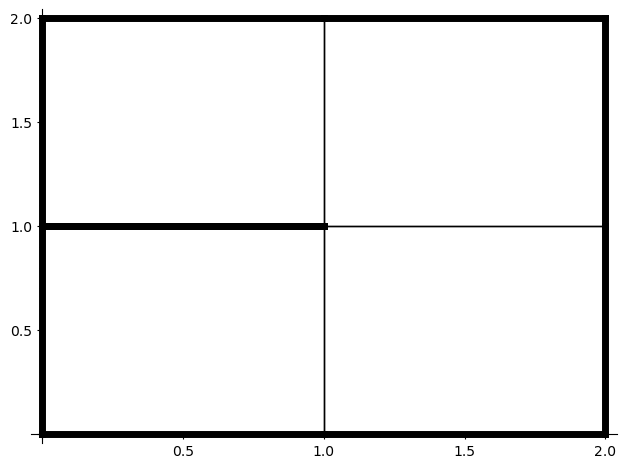

{(0, 0): [(1, 0)],
 (1, 0): [(0, 0), (1, 1)],
 (0, 1): [(1, 1)],
 (1, 1): [(0, 1), (1, 0)]}

In [69]:
L = PseudoMaze(grid=np.array([
    [Cell(1, 0, 1, 1), Cell(1, 1, 0, 0)],
    [Cell(1, 0, 1, 1), Cell(0, 1, 1, 0)]
]))
L.plot_maze()
L.adj